# AWS Deployment and Prediction Example (COVID Edition)

This notebook is for deploying BTNx models for object detection, anomaly detection, and image classification to SageMaker. Please place this notebook and the other files in this directory (e.g. `.mar` files, etc.) in an AWS SageMaker instance, and then run this notebook sequentially to deploy the models.

In [ ]:
!pip install torchserve -q
!pip install nvidia-ml-py3
!pip install --upgrade pip
!pip -q install sagemaker awscli boto3 pandas --upgrade 
!git clone https://github.com/pytorch/serve.git

NOTE: You haven't updated the `sagemaker` in this notebook, whereas it is updated in `oraquick` notebook. Once you upgrade the sagemaker, you are going to have to change a few parameters.

In [1]:
!pip show sagemaker

Name: sagemaker
Version: 1.72.1
Summary: Open source library for training and deploying models on Amazon SageMaker.
Home-page: https://github.com/aws/sagemaker-python-sdk/
Author: Amazon Web Services
Author-email: None
License: Apache License 2.0
Location: /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages
Requires: scipy, protobuf3-to-dict, importlib-metadata, smdebug-rulesconfig, boto3, numpy, packaging, protobuf
Required-by: 


In [2]:
import boto3
import time
import json
import sagemaker

import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import torch

from sagemaker.model import Model
from sagemaker.predictor import RealTimePredictor

## Create a `boto3` session & specify a role with SageMaker access

Create a `boto3` session and get the region, account, and other related information.

In [3]:
sess = boto3.Session()
sm = sess.client('sagemaker')
region = sess.region_name
account = boto3.client('sts').get_caller_identity().get('Account')

In [4]:
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session(boto_session=sess)

In [5]:
bucket_name = sagemaker_session.default_bucket()
prefix = 'torchserve'

In [6]:
bucket_name

'sagemaker-us-east-2-364546270619'

## Model Archive Setup

I have uploaded the `maskrcnn.mar` file in the notebook instance through Jupyter Home. Another strategy would be to upload to Amazon S3 bucket. I think Darrell would know where to best store this in his pipeline.

In [7]:
!ls -lf *.mar

abbott_classifier.mar  btnx_maskrcnn.mar	oraquick_maskrcnn.mar
abbott_maskrcnn.mar    btnx_outlier.mar
btnx_classifier.mar    oraquick_classifier.mar


Create a compressed `.tar.gz` file out of the `maskrcnn.mar` file for Amazon to properly consume the model. Then, upload the model to the S3 bucket under the models' directory.

In [9]:
model_file_name = 'btnx_maskrcnn'
!tar cvfz {model_file_name}.tar.gz {model_file_name}.mar

btnx_maskrcnn.mar


In [10]:
!aws s3 cp {model_file_name}.tar.gz s3://{bucket_name}/{prefix}/models/

upload: ./btnx_maskrcnn.tar.gz to s3://sagemaker-us-east-2-364546270619/torchserve/models/btnx_maskrcnn.tar.gz


In [11]:
model_file_name = 'btnx_classifier'
!tar cvfz {model_file_name}.tar.gz {model_file_name}.mar

btnx_classifier.mar


In [12]:
!aws s3 cp {model_file_name}.tar.gz s3://{bucket_name}/{prefix}/models/

upload: ./btnx_classifier.tar.gz to s3://sagemaker-us-east-2-364546270619/torchserve/models/btnx_classifier.tar.gz


In [8]:
model_file_name = 'btnx_outlier'
!tar cvfz {model_file_name}.tar.gz {model_file_name}.mar

btnx_outlier.mar


In [9]:
!aws s3 cp {model_file_name}.tar.gz s3://{bucket_name}/{prefix}/models/

upload: ./btnx_outlier.tar.gz to s3://sagemaker-us-east-2-364546270619/torchserve/models/btnx_outlier.tar.gz


## Create an Amazon ECR registry

Create a new Docker container registry for the TorchServe container images. Amazon SageMaker pulls the TorchServe conatiner from this registry.

In [10]:
registry_name = 'torchserve'
!aws ecr create-repository --repository-name {registry_name}


An error occurred (RepositoryAlreadyExistsException) when calling the CreateRepository operation: The repository with name 'torchserve' already exists in the registry with id '364546270619'


## Build a TorchServe Docker Container & Push to Amazon ECR

Build a Docker container image locally and push it to the Amazon ECR repository we created in the previous step.

In [11]:
# !sudo chown ec2-user:ec2-user lost+found
!ls -al

total 2175284
drwxr-xr-x  7 ec2-user ec2-user      4096 Nov  3 19:30 .
drwx------ 22 ec2-user ec2-user      4096 Nov  3 19:29 ..
-rw-rw-r--  1 ec2-user ec2-user  49947099 Oct 18 18:28 abbott_classifier.mar
-rw-rw-r--  1 ec2-user ec2-user  49935819 Oct 18 18:29 abbott_classifier.tar.gz
-rw-rw-r--  1 ec2-user ec2-user   9802724 Oct 18 19:19 abbott_deploy_and_predict.ipynb
-rw-rw-r--  1 ec2-user ec2-user 163708310 Oct 18 18:22 abbott_maskrcnn.mar
-rw-rw-r--  1 ec2-user ec2-user 163734196 Oct 18 18:29 abbott_maskrcnn.tar.gz
-rw-rw-r--  1 ec2-user ec2-user    169443 Oct 18 19:04 abbott_sample.jpg
-rw-rw-r--  1 ec2-user ec2-user  50148941 Oct 17 15:44 btnx_classifier.mar
-rw-rw-r--  1 ec2-user ec2-user  50132759 Oct 17 15:45 btnx_classifier.tar.gz
-rw-rw-r--  1 ec2-user ec2-user   3020797 Oct 17 16:43 btnx_deploy_and_predict.ipynb
-rw-rw-r--  1 ec2-user ec2-user 163704698 May  3  2020 btnx_maskrcnn.mar
-rw-rw-r--  1 ec2-user ec2-user 163730663 Oct 17 15:45 btnx_maskrcnn.tar.gz
-rw-rw-r--  1 

In [12]:
image_label = 'v1'
image = f'{account}.dkr.ecr.{region}.amazonaws.com/{registry_name}:{image_label}'

!docker build -t {registry_name}:{image_label} .
!$(aws ecr get-login --no-include-email --region {region})
!docker tag {registry_name}:{image_label} {image}
!docker push {image}

Sending build context to Docker daemon  2.353GB
Step 1/16 : FROM ubuntu:18.04
18.04: Pulling from library/ubuntu

57c49d0f: Pulling fs layer 
40447d26: Pulling fs layer 
Digest: sha256:646942475da61b4ce9cc5b3fadb42642ea90e5d0de46111458e100ff2c7031e6
Status: Downloaded newer image for ubuntu:18.04
 ---> 56def654ec22
Step 2/16 : ENV PYTHONUNBUFFERED TRUE
 ---> Running in 09f24a5e5a36
Removing intermediate container 09f24a5e5a36
 ---> 1da659a80926
Step 3/16 : RUN apt-get update &&     DEBIAN_FRONTEND=noninteractive apt-get install --no-install-recommends -y     fakeroot     ca-certificates     dpkg-dev     g++     python3-dev     openjdk-11-jdk     curl     vim     && rm -rf /var/lib/apt/lists/*     && cd /tmp     && curl -O https://bootstrap.pypa.io/get-pip.py     && python3 get-pip.py
 ---> Running in a469b4ccc086
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic InRelease [242 kB]
Get:3 http://security.ubuntu.com/u

## Deploying Endpoint & Prediction via Amazon SageMaker SDK

**NOTE:** The `model_file_name` parameter can have `_` whereas `sm_model_name` and `endpoint_name` parameters can't have `_` character and so we replace it by `-`. In the Lambda function, refer to the endpoints and hence `-` version.

### Detection Model

In [13]:
model_file_name = 'btnx_maskrcnn'
model_data = f's3://{bucket_name}/{prefix}/models/{model_file_name}.tar.gz'

sm_model_name = 'btnx-maskrcnn'
endpoint_name = 'btnx-maskrcnn'

In [14]:
torchserve_model = Model(model_data=model_data, 
                         image=image,
                         role=role,
                         predictor_cls=RealTimePredictor,
                         name=sm_model_name)

predictor_detector = torchserve_model.deploy(instance_type='ml.m4.xlarge',
                                             initial_instance_count=1,
                                             endpoint_name=endpoint_name)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: btnx-maskrcnn


ClientError: An error occurred (ValidationException) when calling the CreateEndpoint operation: Cannot create already existing endpoint "arn:aws:sagemaker:us-east-2:364546270619:endpoint/btnx-maskrcnn".

### Classification Model

In [16]:
model_file_name = 'btnx_classifier'
model_data = f's3://{bucket_name}/{prefix}/models/{model_file_name}.tar.gz'

sm_model_name = 'btnx-classifier'
endpoint_name = 'btnx-classifier'

In [17]:
torchserve_model = Model(model_data=model_data, 
                         image=image,
                         role=role,
                         predictor_cls=RealTimePredictor,
                         name=sm_model_name)

predictor_classifier = torchserve_model.deploy(instance_type='ml.m4.xlarge',
                                               initial_instance_count=1,
                                               endpoint_name=endpoint_name)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

(800, 600, 3)


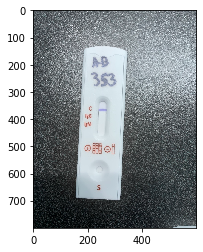

In [17]:
# file_name = 'btnx_sample.jpg'
file_name = 'initial_image.jpg'
with open(file_name, 'rb') as f:
    payload = f.read()
    
image = cv2.imread(file_name)
H, W, C = image.shape
print((H, W, C))
plt.imshow(image)
plt.show()

In [18]:
response = predictor_detector.predict(data=payload)

NameError: name 'predictor_detector' is not defined

In [ ]:
response

In [54]:
with open('detection_response.txt', 'w') as f:
    f.write(response.decode("utf-8"))

In [55]:
output = json.loads(response)

In [56]:
len(output)

2

In [57]:
output[1]['label']

'kit'

### Outlier Model

In [13]:
model_file_name = 'btnx_outlier'
model_data = f's3://{bucket_name}/{prefix}/models/{model_file_name}.tar.gz'

sm_model_name = 'btnx-outlier'
endpoint_name = 'btnx-outlier'

In [14]:
torchserve_model = Model(model_data=model_data, 
                         image=image,
                         role=role,
                         predictor_cls=RealTimePredictor,
                         name=sm_model_name)

predictor_outlier = torchserve_model.deploy(instance_type='ml.t2.medium',
                                            initial_instance_count=1,
                                            endpoint_name=endpoint_name)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

(176, 108, 3)


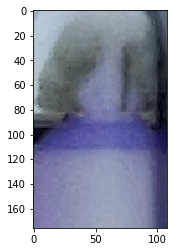

In [15]:
file_name = 'invalid_zone.jpg'
with open(file_name, 'rb') as f:
    payload = f.read()
    
image = cv2.imread(file_name)
H, W, C = image.shape
print((H, W, C))
plt.imshow(image)
plt.show()

In [16]:
response = predictor_outlier.predict(data=payload)

In [17]:
response

b'[\n  {\n    "anomaly_detection": "1",\n    "loss": "3.758268117904663"\n  }\n]'

## Custom Utilities, Orientation Fix, Membrane Cropping

Now that we get the desired outputs, lets process them to get the membrane. First, let's create some utility functions mainly for orientation fix and getting bbox coordinates.

In [19]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def get_corners(array):
    H,W,C = array.shape
    left_edges = np.where(array.any(axis=1),array.argmax(axis=1),W+1)
    flip_lr = cv2.flip(array,1) #1 horz vert 0
    right_edges = W-np.where(flip_lr.any(axis=1),flip_lr.argmax(axis=1),W+1)
    top_edges = np.where(array.any(axis=0),array.argmax(axis=0),H+1)
    flip_ud = cv2.flip(array,0) #1 horz vert 0
    bottom_edges = H - np.where(flip_ud.any(axis=0),flip_ud.argmax(axis=0),H+1)
    leftmost = left_edges.min()
    rightmost = right_edges.max()
    topmost = top_edges.min()
    bottommost = bottom_edges.max()
    return leftmost, rightmost, topmost, bottommost

def rotatedRectWithMaxArea(w, h, angle):
    """
    https://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle (maximal area) within the rotated rectangle.
    """
    if w <= 0 or h <= 0:
        return 0,0
    
    width_is_longer = w >= h
    side_long, side_short = (w,h) if width_is_longer else (h,w)
    
    # since the solutions for angle, -angle and 180-angle are all the same,
    # if suffices to look at the first quadrant and the absolute values of sin,cos:
    sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
    if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
        # half constrained case: two crop corners touch the longer side,
        #   the other two corners are on the mid-line parallel to the longer line
        x = 0.5*side_short
        wr,hr = (x/sin_a,x/cos_a) if width_is_longer else (x/cos_a,x/sin_a)
    else:
        # fully constrained case: crop touches all 4 sides
        cos_2a = cos_a*cos_a - sin_a*sin_a
        wr,hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a
        
    w_bb = w*cos_a + h*sin_a
    h_bb = w*sin_a + h*cos_a
    inset_horizontal = (w_bb - wr) / 2
    inset_vertical = (h_bb - hr) / 2
    
    # return wr, hr
    return round(wr), round(hr), round(inset_horizontal), round(inset_vertical)

In [59]:
labels = [pred['label'] for pred in output]
scores = [eval(pred['score']) for pred in output]
labels, scores

(['membrane', 'kit'], [0.9992854, 0.99736893])

In [60]:
boxes = np.array([eval(pred['box']) for pred in output])
masks = np.array([eval(pred['mask']) for pred in output])
boxes.shape, masks.shape

((2, 2, 2), (2, 1, 800, 600))

In [61]:
try:
    kit_loc, membrane_loc = labels.index('kit'), labels.index('membrane')
    kit_score, membrane_score = scores[kit_loc], scores[membrane_loc]
except:
    raise ValueError('Either kit or membrane is missing from the prediction or the image')

In [62]:
if kit_score < 0.85 or membrane_score < 0.85:
    raise ValueError('Either kit or membrane has low confidence!')

In [63]:
kit_box, membrane_box = boxes[kit_loc, :], boxes[membrane_loc, :]
kit_mask, membrane_mask = masks[kit_loc, :, :, :], masks[membrane_loc, :, :, :]

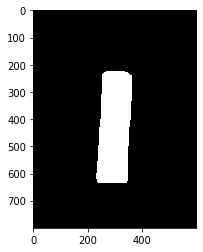

In [64]:
kit_mask[kit_mask >= 0.85] = 1.
kit_mask[kit_mask < 0.85] = 0.
kit_mask = np.array(np.concatenate([kit_mask.reshape((H, W, 1)) * 255] * 3, axis=-1), dtype=np.uint8)
plt.imshow(kit_mask)
plt.show()

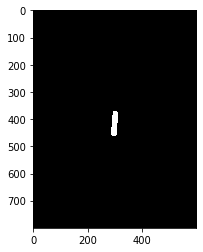

In [65]:
membrane_mask[membrane_mask >= 0.85] = 1.
membrane_mask[membrane_mask < 0.85] = 0.
membrane_mask = np.array(np.concatenate([membrane_mask.reshape((H, W, 1)) * 255] * 3, axis=-1), dtype=np.uint8)
plt.imshow(membrane_mask)
plt.show()

In [66]:
global_lefttop = (0, 0)
global_righttop = (0, W)
global_letfbottom = (H, 0)
global_rightbottom = (H, W)

kit_mask_coordinates = np.argwhere(kit_mask[:, :, 0] == 255)

lefttop_distances = np.sum((kit_mask_coordinates  - global_lefttop)**2, axis=1)
righttop_distances = np.sum((kit_mask_coordinates  - global_righttop)**2, axis=1)
leftbottom_distances = np.sum((kit_mask_coordinates  - global_letfbottom)**2, axis=1)
rightbottom_distances = np.sum((kit_mask_coordinates  - global_rightbottom)**2, axis=1)

lefttop_coordinates = kit_mask_coordinates[np.argmin(lefttop_distances)]
righttop_coordinates = kit_mask_coordinates[np.argmin(righttop_distances)]
leftbottom_coordinates = kit_mask_coordinates[np.argmin(leftbottom_distances)]
rightbottom_coordinates = kit_mask_coordinates[np.argmin(rightbottom_distances)]


left_angle = math.atan((leftbottom_coordinates[1] - lefttop_coordinates[1]) / 
                       (leftbottom_coordinates[0] - lefttop_coordinates[0])) * (180 / math.pi)

right_angle = math.atan((rightbottom_coordinates[1] - righttop_coordinates[1]) /
                        (rightbottom_coordinates[0] - righttop_coordinates[0])) * (180 / math.pi)

angle = int(round((left_angle + right_angle) / 2))
print('CONSENSUS ANGLE: ', angle)

CONSENSUS ANGLE:  -3


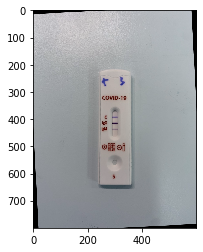

In [67]:
rotated_image = rotate_image(image, -angle)
plt.imshow(rotated_image)
plt.show()

242 358 224 636


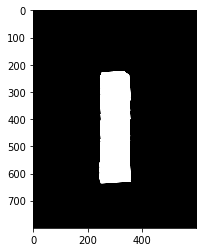

In [68]:
rotated_kit_mask = rotate_image(kit_mask, -angle)
kit_xmin, kit_xmax, kit_ymin, kit_ymax = get_corners(rotated_kit_mask)
print(kit_xmin, kit_xmax, kit_ymin, kit_ymax)
plt.imshow(rotated_kit_mask)
plt.show()

287 311 369 462


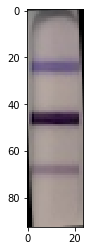

In [69]:
membrane_xmin, membrane_xmax, membrane_ymin, membrane_ymax = get_corners(membrane_mask)
rotated_membrane = rotate_image(image[membrane_ymin: membrane_ymax, membrane_xmin: membrane_xmax, :], -angle)
print(membrane_xmin, membrane_xmax, membrane_ymin, membrane_ymax)
plt.imshow(rotated_membrane)
plt.show()

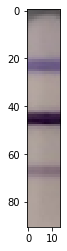

In [70]:
ymax, xmax, ymin, xmin = rotatedRectWithMaxArea(rotated_membrane.shape[0], 
                                                rotated_membrane.shape[1], 
                                                angle * (math.pi / 180))
best_rotated_membrane = rotated_membrane[ymin: ymax, xmin: xmax, :]
plt.imshow(best_rotated_membrane)
plt.show()

## Classification and Diagnosis!

**NOTE:** We won't be rotating the membrane any further, the model implicitly takes care of the rest!

In [18]:
cv2.imwrite('extracted_membrane.jpg', best_rotated_membrane)

NameError: name 'best_rotated_membrane' is not defined

In [19]:
with open('extracted_membrane.jpg', 'rb') as f:
    payload = f.read()
    payload = payload
    
response = predictor_classifier.predict(data=payload)

In [20]:
with open('classification_response.txt', 'w') as f:
    f.write(response.decode("utf-8"))

In [21]:
output = json.loads(response)

In [22]:
output

[{'zone_classification': '[1, 0, 0]', 'diagnosis': '0'}]

In [23]:
zone_classification = eval(output[0]['zone_classification'])
diagnosis = eval(output[0]['diagnosis'])
if diagnosis == 0:
    print('NEGATIVE')
elif diagnosis == 1:
    print('POSITIVE')
else:
    print('INVALID')

NEGATIVE


In [77]:
zone_classification

[1, 1]

In [ ]:
!pip freeze > requirements.txt